# 前情函数

In [1]:
import torch

## GPU相关语句

In [2]:
'''以下通过先判断GPU是否存在，
   在通过对应的语句打印出GPU的信息
'''

if torch.cuda.is_available():
    # 返回gpu数量
    GPU_num = torch.cuda.device_count()
    # 返回gpu名字，设备索引默认从0开始
    GPU_name = torch.cuda.get_device_name(0)
    # 返回当前设备索引
    GPU_index = torch.cuda.current_device()
    print(GPU_num, GPU_name, GPU_index)
else:
    print('Use CPU for work')

1 GeForce GTX 960M 0


下面语句用于将模型放在GPU上训练

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

device

device(type='cuda', index=0)

## torch.unsqueeze 与 torch.squeeze 

torch.unsqueeze(input, dim) → Tensor  

&ensp;&ensp;&ensp;&ensp;返回插入指定位置尺寸为1的新张量

&ensp;&ensp;&ensp;&ensp;返回的张量与此张量共享相同的基础数据

&ensp;&ensp;&ensp;&ensp;可以通过`dim`控制指定的轴向

这个函数主要是对数据维度进行扩充。给指定位置加上维数为1的维度

In [4]:
x0 = torch.tensor([1, 2, 3, 4])
print('x0 维度:', x0.size(),'\n', x0)

x1 = torch.unsqueeze(x0, 0)
print('x1 维度:', x1.size(),'\n', x1)

x2 = torch.unsqueeze(x0, 1)
print('x2 维度:', x2.size(),'\n', x2)

x0 维度: torch.Size([4]) 
 tensor([1, 2, 3, 4])
x1 维度: torch.Size([1, 4]) 
 tensor([[1, 2, 3, 4]])
x2 维度: torch.Size([4, 1]) 
 tensor([[1],
        [2],
        [3],
        [4]])


torch.squeeze(input, dim=None, out=None) → Tensor

&ensp;&ensp;&ensp;&ensp;移除输入张量维度为1的轴

&ensp;&ensp;&ensp;&ensp;例如输入张量的shape为: $(A \times 1 \times B \times C \times 1 \times D)$输出张量的shape则为:$(A \times B \times C \times D)$

&ensp;&ensp;&ensp;&ensp;可以通过`dim`控制指定的轴向，例如输入张量的shape为: $(A \times 1 \times B)$，通过`squeeze(input, 1)`，输出张量的shape为: $(A \times B)$


这个函数主要对数据的维度进行压缩，去掉维数为1的的维度

In [5]:
x0 = torch.zeros(2, 1, 2, 1, 2)
print('x0 维度:', x0.size())

x1 = torch.squeeze(x0)
print('x1 维度:', x1.size())

x2 = torch.squeeze(x0, 0)
print('x2 维度:', x2.size())

x3 = torch.squeeze(x0, 1)
print('x3 维度:', x3.size())

x0 维度: torch.Size([2, 1, 2, 1, 2])
x1 维度: torch.Size([2, 2, 2])
x2 维度: torch.Size([2, 1, 2, 1, 2])
x3 维度: torch.Size([2, 2, 1, 2])


# 正式开始

## 导入必要模块  
安装`pytorch`时，不会安装`torchsummary`，需要手动通过`!pip install torchsummary`安装，如果不在`jupyter`中，则去掉感叹号进行安装

In [6]:
%matplotlib inline

In [7]:
import torch
from torchsummary import summary
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pylab as pl
from IPython import display

torch.__version__

'1.6.0'

## 构建数据集  
本案例中将以一个正弦函数$y=sin(x)$为例

如果使用多个GPU，应该使用`torch.cuda.manual_seed_all()`为所有的GPU设置种子。

In [8]:
if torch.cuda.is_available():
    torch.cuda.manual_seed(1) #为当前GPU设置随机种子用于生成随机数，以使得结果是确定的
    print('GPU is available')
else:
    torch.manual_seed(1)      #为CPU设置随机种子用于生成随机数，以使得结果是确定的
    print('Use CPU for work')

GPU is available


`squeeze`是删除维度为1的轴，`unsqueeze`则是增加一个维度为1的轴，通过`dim`控制增加轴的方向，其中可以通过`x.size()`获取`x`的维度为`torch.Size([100, 1])`

In [9]:
import math

PI = math.pi

x = torch.unsqueeze(torch.linspace(-PI, PI, 200), dim=1)

y = torch.sin(x) + 0.07 * torch.randn(x.size())

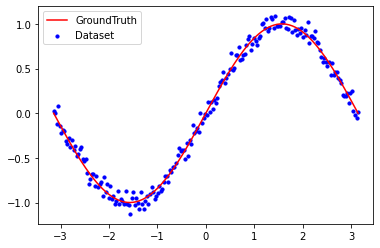

In [10]:
plt.plot(x, torch.sin(x).numpy(), color='r', label='GroundTruth')
plt.scatter(x.numpy(), y.numpy(), s=10, color='b', label='Dataset')
plt.legend()
plt.show()

## 模型定义  
采用`relu`激活函数，单隐层神经网络结构

In [11]:
class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)
        self.predict = torch.nn.Linear(n_hidden, n_output)

    def forward(self, x):
        x = F.relu(self.hidden(x))
        x = self.predict(x)
        return x

开启GPU模式并查看网络摘要`summary`

In [12]:
net = Net(n_feature=1, n_hidden=10, n_output=1).to(device)

summary(net, input_size=(1,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]              20
            Linear-2                    [-1, 1]              11
Total params: 31
Trainable params: 31
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


## 模型参数设置  
优化器以及损失函数设置

In [13]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.02)

loss_func = torch.nn.MSELoss()

将数据拷贝至GPU

In [14]:
x_data, y_data = x.to(device), y.to(device)

Pytorch参数重置，避免调参后重新运行for循环时，原始已训练参数进行保留

In [15]:
def weight_reset(m):
    if isinstance(m, torch.nn.Conv2d) or isinstance(m, torch.nn.Linear):
        m.reset_parameters()

Wall time: 31.3 s


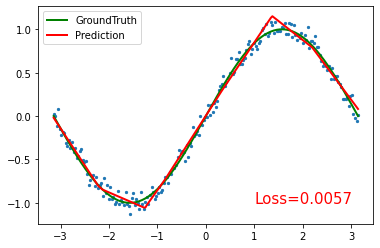

In [16]:
%%time

net.apply(weight_reset)

loss_value = []

for i in range(1000):
    prediction = net(x_data)
    
    loss = loss_func(prediction, y_data)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_value.append(loss.cpu().detach().numpy())

    if i % 10 == 0:
        pl.axis([-4, 4, -2, 2]) 
        pl.clf()
        pl.scatter(x.numpy(), y.numpy(), s=5)
        pl.plot(x.numpy(), torch.sin(x).numpy(), 'g', lw=2, label='GroundTruth')
        pl.plot(x.numpy(), prediction.cpu().detach().numpy(), 'r-', lw=2, label='Prediction')
        pl.text(1.0, -1.0, 'Loss=%.4f' % loss.cpu().detach().numpy(), fontdict={'size': 15, 'color':  'red'})
        pl.legend()
        display.display(pl.gcf())
        display.clear_output(wait=True)

损失值可视化

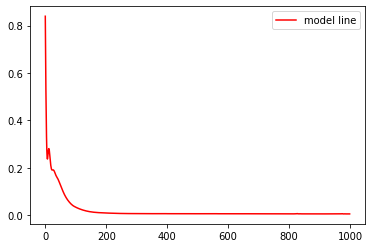

In [17]:
pl.plot([i for i in range(len(loss_value))], loss_value, label='model line', color='r')
pl.legend()
pl.show()